# Parallelization con LangGraph

## Definición (nivel MIT/Stanford, aplicada)
Parallelization divide en subproblemas independientes y ejecuta ramas al mismo tiempo para reducir tiempo de respuesta.

## Cuándo usarla
Úsala cuando opener, follow-up y guardrails pueden calcularse en paralelo sin dependencia fuerte.

## Cuándo NO usarla
Evítala cuando las ramas dependen del mismo razonamiento acumulado; ahí conviene secuencial.

## Diagrama Conceptual

```mermaid
graph TD
A[Contexto] --> B[Rama Opener]
A --> C[Rama Follow-up]
A --> D[Rama Tono]
B --> E[Agregador]
C --> E
D --> E
```

In [1]:
# Setup de clase
from __future__ import annotations

import importlib.util
import inspect
import json
import sys
from pathlib import Path
from IPython.display import Image, Markdown, display


def find_repo_root(start: Path) -> Path:
    for p in [start, *start.parents]:
        if (p / "pyproject.toml").exists():
            return p
    raise RuntimeError("No se encontro raiz del repo")


def load_module(path: Path, module_name: str):
    spec = importlib.util.spec_from_file_location(module_name, path)
    module = importlib.util.module_from_spec(spec)
    if spec is None or spec.loader is None:
        raise RuntimeError(f"No se pudo cargar modulo: {path}")
    sys.modules[module_name] = module
    spec.loader.exec_module(module)
    return module

ROOT = find_repo_root(Path.cwd())
print(f"Repo root: {ROOT}")

Repo root: /Users/carlosdaniel/Documents/Projects/labor_projects/Henry/2026/01-introduction_ai_engineering/ai_engineering_henry


In [2]:
script_path = ROOT / '04_langchain_langgraph/02_parallelization/Notebooks/01_parallelization_langgraph.py'
module = load_module(script_path, 'nb_parallel')
run_fn = module.run_parallelization
print('Script:', script_path)
print('Función:', run_fn.__name__)

Script: /Users/carlosdaniel/Documents/Projects/labor_projects/Henry/2026/01-introduction_ai_engineering/ai_engineering_henry/04_langchain_langgraph/02_parallelization/Notebooks/01_parallelization_langgraph.py
Función: run_parallelization


## Código de la arquitectura (visible en notebook)

In [3]:
print(inspect.getsource(run_fn)[:5000])

def run_parallelization(profile: dict | None = None, verbose: bool = True) -> dict:
    root = find_repo_root(Path.cwd())
    load_dotenv(root / ".env")
    api_key = os.getenv("OPENAI_API_KEY")
    if not api_key:
        raise RuntimeError("OPENAI_API_KEY no esta definida en .env")

    model = os.getenv("OPENAI_MODEL", "gpt-4o-mini")
    llm = ChatOpenAI(model=model, temperature=0.6, api_key=api_key)

    build_context_packet = load_context_builder(root)
    if profile is None:
        profile = {
            "tipo_persona": "cirujana cardiovascular con pasion por ballet clasico",
            "gustos": ["teatro de camara", "vinos biodinamicos", "alpinismo de altura"],
            "estilo": "precisa, elegante, conversacion intelectual",
            "contexto": "match con perfil verificado, ella dio like primero",
        }
    context_packet = build_context_packet(profile=profile, architecture="parallelization")

    def build_opener(state: ParallelState) -> dict:
        prompt = Ch

## Ejemplo 1: caso base del curso

In [4]:
result_1 = run_fn(verbose=False)
print('Modelo:', result_1['__model'])
print('Context hash:', result_1['__context_hash'])

Modelo: gpt-4o-mini
Context hash: 1e14cc6cc1cc


In [5]:
print('Salida final ejemplo 1:')
print(json.dumps(result_1['final'], ensure_ascii=False, indent=2))

Salida final ejemplo 1:
{
  "opener": "Hola, es un placer conectar contigo. Me fascina la precisión y elegancia que ambos compartimos en nuestras pasiones, desde la cirugía cardiovascular hasta el ballet clásico. Me encantaría saber más sobre tu experiencia en alpinismo de altura y, quizás, compartir una copa de vino biodinámico después de una función de teatro de cámara. ¿Qué opinas?",
  "follow_up": "Es genial ver que compartimos el gusto por el teatro de cámara. ¿Tienes alguna obra favorita que hayas visto recientemente? Además, me encantaría saber más sobre tu pasión por el alpinismo de altura, ¿cuál ha sido tu experiencia más memorable en las montañas?",
  "tone_notes": [
    "precisa",
    "elegante",
    "conversacion intelectual"
  ],
  "avoid": [
    "manipulacion",
    "presion",
    "lenguaje explicito"
  ],
  "why_it_works": [
    "Establece una conexión inmediata a través de intereses compartidos.",
    "Invita a una conversación profunda sin presión.",
    "Refleja un ton

## Grafo real LangGraph (comportamiento)

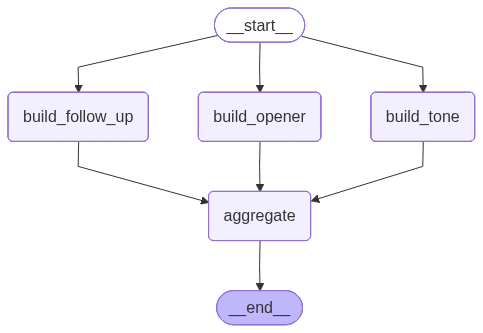

In [6]:
agent = result_1['__agent']
try:
    display(Image(agent.get_graph().draw_mermaid_png()))
except Exception as exc:
    print('No se pudo renderizar PNG en este entorno:', exc)
    display(Markdown('```mermaid\n' + result_1['__graph_mermaid'] + '\n```'))

## Ejemplo 2: asistente latino experto en enamorar (coqueteo creativo y respetuoso)

In [7]:
profile_coqueteo = {
  "tipo_persona": "asistente latino experto en enamorar con elegancia",
  "gustos": [
    "salsa romantica",
    "cafes bohemios",
    "poesia urbana",
    "paseos nocturnos"
  ],
  "estilo": "carismatico, coqueto, respetuoso, humor picante sutil",
  "contexto": "quiere iniciar una conversacion de coqueteo sin caer en frases prefabricadas"
}
result_2 = run_fn(profile=profile_coqueteo, verbose=False)
print('Context hash coqueteo:', result_2['__context_hash'])

Context hash coqueteo: feb36c206839


In [8]:
print('Salida final ejemplo coqueteo:')
print(json.dumps(result_2['final'], ensure_ascii=False, indent=2))

Salida final ejemplo coqueteo:
{
  "opener": "Hola, ¿te gustaría compartir un café en un rincón bohemio mientras escuchamos un poco de salsa romántica? Creo que entre un verso de poesía urbana y otro, podríamos perder la noción del tiempo en un paseo nocturno lleno de magia.",
  "follow_up": "¿Cuál es tu café bohemio favorito para disfrutar de una buena charla? Me encantaría saber si compartimos el gusto por algún lugar especial.",
  "tone_notes": [
    "carismatico",
    "coqueto",
    "respetuoso",
    "humor picante sutil"
  ],
  "avoid": [
    "manipulacion",
    "presion",
    "lenguaje explicito"
  ],
  "why_it_works": [
    "Invita a una experiencia compartida y romántica.",
    "Incorpora intereses comunes que generan conexión.",
    "Fomenta una conversación fluida y amena sin caer en clichés."
  ]
}


## Errores típicos en producción
- Elegir esta arquitectura por moda y no por necesidad.
- No definir métricas de calidad/costo/latencia antes de escalar.
- No versionar contexto ni criterios de evaluación.
- Falta de observabilidad para diagnosticar degradaciones.

## Lectura crítica del resultado
- Evalúa si el flujo realmente mejoró calidad o solo añadió complejidad.
- Compara latencia/costo vs beneficio de control arquitectónico.
- Decide si esta arquitectura es mínima suficiente para tu caso real.